In [7]:
#import everything here
import vireoSNP
import numpy as np
import pandas as pd

from scipy.io import mmread
from scipy.io import mmwrite
import seaborn as sns
import matplotlib.pyplot as plt
from vireoSNP import BinomMixtureVB
from vireoSNP.plot.base_plot import heat_matrix
from mquad.mquad_utils import findKnee, plot_confusionMatrix, confusionMatrix

from matplotlib import cm as cmp
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

print(vireoSNP.__version__)
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


## Input data
Here we import the AD and DP matrices of informative mtDNA variants detected by MQuad.

In [8]:
mquad_AD = mmread('data/mquad/passed_ad.mtx').tocsc()
mquad_DP = mmread('data/mquad/passed_dp.mtx').tocsc()

mquad_AD.shape, mquad_DP.shape

((24, 77), (24, 77))

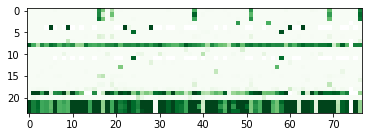

In [9]:
with open('data/mquad/passed_variant_names.txt') as f:
    var = f.readlines()

var = [x.strip() for x in var]

AD_df = pd.DataFrame(mquad_AD.todense(), index=var)
DP_df = pd.DataFrame(mquad_DP.todense(), index=var)

plt.imshow(AD_df/DP_df, cmap='Greens')

AF_df = AD_df/DP_df
AF_df = AF_df.fillna(0)


## Assign clones with vireo (Fig. 3a,b, S4a)
Here we assign each cell to a clone using mtDNA variants found by MQuad. After that we compare the assignment concordance with nuclear clone labels. 

In [10]:
np.random.seed(42)
_model = BinomMixtureVB(n_var=len(mquad_AD.getnnz(axis=1)), n_cell=len(mquad_AD.getnnz(axis=0)), n_donor=3)
_model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=300)

mquad_modelCA = _model

Precision = 0.8484848484848485
Recall = 0.8888888888888888


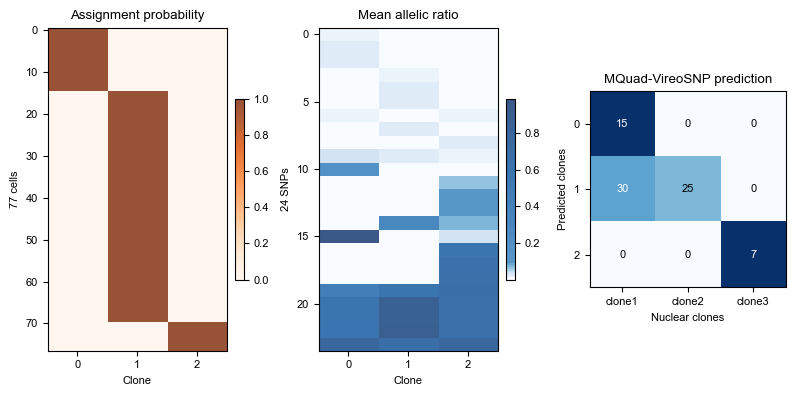

In [24]:
def plot_figure_S4a(ID_prob, model):
    im = heat_matrix(ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Assignment probability")
    plt.xlabel("Clone")
    plt.ylabel("%d cells" %(model.n_cell))
    plt.xticks(range(model.n_donor))
    plt.tight_layout()


def segment_cmp(cmap):
    top = cmp.get_cmap(cmap, 200)

    newcolors = np.vstack((top(np.linspace(0, 0.7, 10)),
                        top(np.linspace(0.7, 1, 90))))
    newcmp = ListedColormap(newcolors, name='segBlues')

    return newcmp

def plot_figure_3a(AF, model, cmp):
    im = heat_matrix(AF, cmap=cmp, alpha=0.8, 
                display_value=False, row_sort=True, interpolation='none', aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Mean allelic ratio")
    plt.xlabel("Clone")
    plt.ylabel("%d SNPs" %(model.n_var))
    plt.xticks(range(model.n_donor))
    plt.tight_layout()


def plot_figure_3b(ID_prob, ax):
    clone_id = np.argmax(ID_prob, axis=1)
    real_df = pd.read_csv('data/cardelino_clones_files.csv')
    real_lab = [i for i in real_df.V2 if i != 'unassigned']
    confusion = confusionMatrix(clone_id, real_lab)
    #confusion = confusion[["Clone 1", "Clone 2", "Clone 3"]]
    res = plot_confusionMatrix(confusion, ax)
    plt.title('MQuad-VireoSNP prediction')
    plt.ylabel('Predicted clones')
    plt.xlabel('Nuclear clones')
    plt.xticks(range(3), confusion.columns)
    plt.yticks(range(len(confusion)), set(clone_id))
    plt.tight_layout()


fig = plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
ID_prob_sorted = np.array([[i[2], i[0], i[1]]for i in mquad_modelCA.ID_prob])
plot_figure_S4a(ID_prob_sorted, mquad_modelCA)

ax = plt.subplot(1,3,2)
AF_SNPs = mquad_modelCA.beta_mu
#rearrange clones to match fig 3a
AF_SNPs_sorted = np.array([[i[2], i[0], i[1]]for i in AF_SNPs])
#plot_figure_3a(AF_SNPs_sorted, mquad_modelCA, segment_cmp('Blues'))
plot_figure_3a(AF_SNPs_sorted, mquad_modelCA, segment_cmp('Blues'))

#mquad confusion matrix
ax = plt.subplot(1,3,3)
plot_figure_3b(ID_prob_sorted, ax)

## Gene expression analysis (Fig. 3d, e)
The GE analysis was performed in R with DESeq2 (DE_fibroblast.R). Here we simply import dataframe outputs from R to do the plotting.

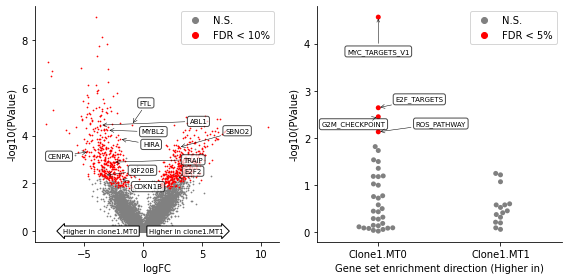

In [12]:
## Import gene expression analysis from R
from matplotlib.pyplot import Line2D
from adjustText import adjust_text
import re

def plot_figure_3d(ax):
    de_tab = pd.read_csv('data/de_tab.csv', index_col=0)
    de_tab_sig = de_tab[de_tab.sig == True]
    de_tab_not_sig = de_tab[de_tab.sig == False]

    ax.scatter(de_tab_not_sig.logFC, -np.log10(de_tab_not_sig.PValue), color = 'grey', label = 'N.S.', s=0.5)
    ax.scatter(de_tab_sig.logFC, -np.log10(de_tab_sig.PValue), color='r', label = 'FDR < 10%', s=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    legend_elements = [Line2D([0], [0], marker = 'o', color = 'grey', label = 'N.S.', linestyle = 'None'), 
    Line2D([0], [0], marker = 'o', color = 'r', label = 'FDR < 10%', linestyle = 'None')]
    ax.legend(handles = legend_elements)
    ax.text(-0.5, 0, 'Higher in clone1.MT0', ha='right', va='center', bbox = dict(boxstyle="larrow", fc='white', lw=1), fontsize = 7)
    ax.text(0.5, 0, 'Higher in clone1.MT1', ha='left', va='center', bbox = dict(boxstyle="rarrow", fc='white', lw=1), fontsize = 7)
    plt.xlabel('logFC')
    plt.ylabel('-log10(PValue)')

    texts = []
    props = dict(boxstyle='round', alpha = 0.7, facecolor='white')
    for x,y,s in zip(de_tab_sig[de_tab_sig.lab.notnull()].logFC, -np.log10(de_tab_sig[de_tab_sig.lab.notnull()].PValue), de_tab_sig[de_tab_sig.lab.notnull()].lab):
        texts.append(plt.text(x,y,s, fontsize = 7, bbox=props))

    adjust_text(texts, force_text = 1.5, force_points = 1.5, expand_points=(1.5, 2), expand_text=(1.5, 1.5), arrowprops = dict(arrowstyle="->", color='black', lw=0.5))

    plt.tight_layout()

def plot_figure_3e(ax):
    cam_H_pw = pd.read_csv('data/cam_H_pw.csv', index_col=0)
    cam_H_pw_not_sig = cam_H_pw[cam_H_pw.sig == False]
    cam_H_pw_sig = cam_H_pw[cam_H_pw.sig == True]
    #cam_H_pw.head()

    sns.swarmplot(x = cam_H_pw.Direction, y = -np.log10(cam_H_pw.PValue), hue = cam_H_pw.sig, palette = ['grey', 'r'], ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    texts=[]
    props = dict(boxstyle='round', alpha = 0.7, facecolor='white')
    for y,s in zip(-np.log10(cam_H_pw_sig[cam_H_pw_sig.lab.notnull()].PValue), cam_H_pw_sig[cam_H_pw_sig.lab.notnull()].lab):
        if s != "HALLMARK_MYC_TARGETS_V1":
            s = re.sub("HALLMARK_", "", s)
            texts.append(plt.text(0,y,s, fontsize = 7, bbox=props))

    adjust_text(texts, force_text = 1.5, force_points = 1.5, expand_points=(1.5, 2), expand_text=(1.5, 1.5), autoalign='y', ha='left',arrowprops = dict(arrowstyle="->", color='black', lw=0.5))

    ##separately annotate myc targets to avoid overlapping with legend
    ax.annotate("MYC_TARGETS_V1", xy=(0,-np.log10(0.000027)), xytext=(0,3.8), bbox=props, fontsize = 7, ha='center', arrowprops = dict(arrowstyle="->", color='black', lw=0.5))

    legend_elements = [Line2D([0], [0], marker = 'o', color = 'grey', label = 'N.S.', linestyle = 'None'), 
    Line2D([0], [0], marker = 'o', color = 'r', label = 'FDR < 5%', linestyle = 'None')]
    ax.legend(handles = legend_elements)
    plt.xticks(range(2), ['Clone1.MT0', 'Clone1.MT1'])
    plt.xlabel('Gene set enrichment direction (Higher in)')
    plt.ylabel('-log10(PValue)')

    plt.tight_layout()

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plot_figure_3d(ax)

ax = plt.subplot(1,2,2)
plot_figure_3e(ax)


Now we just need to put everything together and leave some space for Fig. 3c, which is added in manually after.

Precision = 0.8484848484848485
Recall = 0.8888888888888888


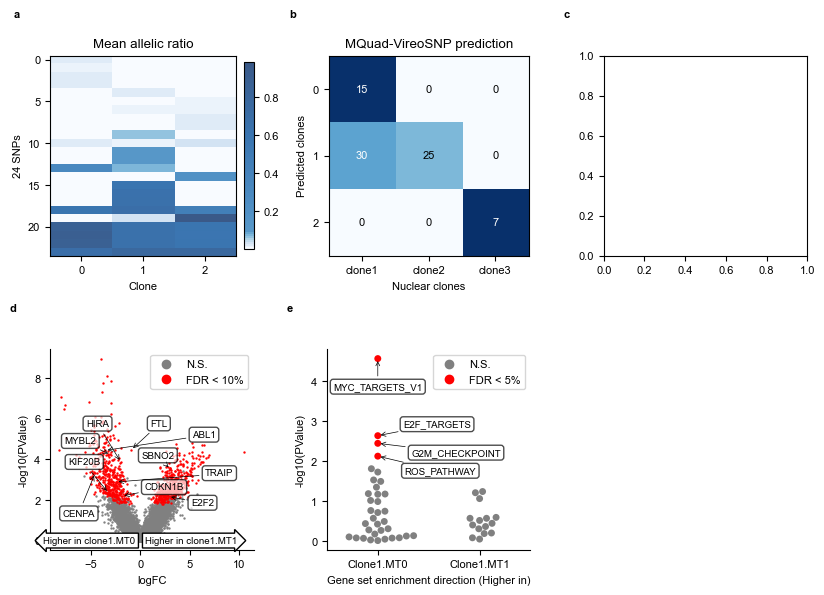

In [13]:
plt.style.use('default')
font = {'family' : 'Arial',
        'size'   : 8}
plt.rc('font', **font)
cm = 1/2.54

fig = plt.figure(figsize=(8.3,6), dpi=100)

ax1 = plt.subplot(2,3,1)
ax1.text(-0.5*cm, 3*cm, 'a', transform = ax1.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_3a(AF_SNPs, mquad_modelCA, segment_cmp('Blues'))

#mquad confusion matrix
ax2 = plt.subplot(2,3,2)
ax2.text(-0.5*cm, 3*cm, 'b', transform = ax2.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_3b(ID_prob_sorted, ax2)

ax3 = plt.subplot(2,3,4)
ax3.text(-0.5*cm, 3*cm, 'd', transform = ax3.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_3d(ax3)

ax4 = plt.subplot(2,3,5)
ax4.text(-0.5*cm, 3*cm, 'e', transform = ax4.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_3e(ax4)

ax5 = plt.subplot(2,3,3)
ax5.text(-0.5*cm, 3*cm, 'c', transform = ax5.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plt.tight_layout()
#plt.savefig('figures/tmp.svg')

## Supplementary Fig. S4

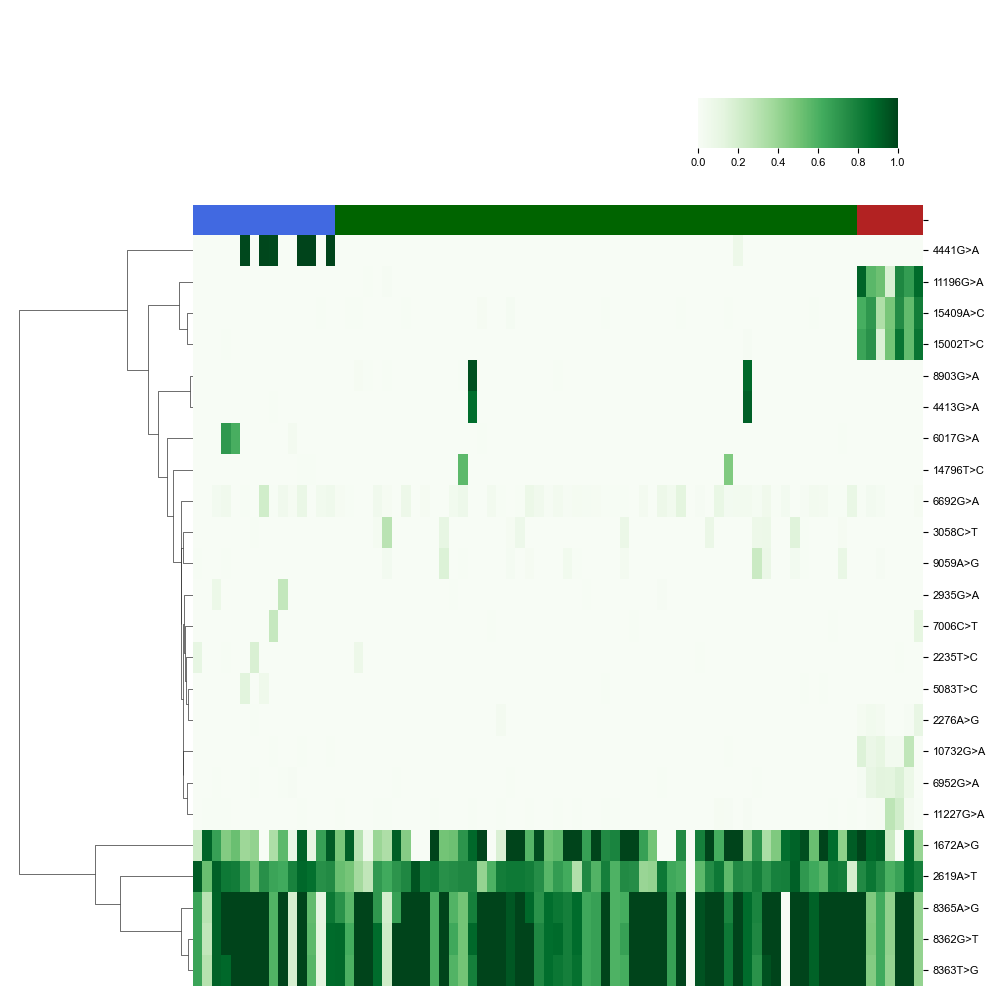

In [14]:
clone_id = np.argmax(ID_prob_sorted, axis=1)
col_idx = np.argsort(clone_id)
sorted_AF = AF_df.loc[:, col_idx]

clone_pal = ['royalblue', 'darkgreen', 'firebrick']
clone_lut = dict(zip(set(clone_id), clone_pal))
clone_colors = pd.Series(clone_id).map(clone_lut)

g = sns.clustermap(sorted_AF, col_cluster = False, row_cluster = True, xticklabels = False, cmap = 'Greens', col_colors = clone_colors, cbar_kws = dict(use_gridspec=False,orientation="horizontal"))
g.cax.set_position([.7, 0.85, .2, 0.05])

In [15]:
## save the clone assignment to pipe into R for DE analysis
real_df = pd.read_csv('data/cardelino_clones_files.csv')
real_lab = [i for i in real_df.V2 if i != 'unassigned']
d = {'mquad': clone_id, 'cardelino': real_lab}
clone_df = pd.DataFrame(d)
clone_df['combined'] = clone_df.cardelino + '.MT' + clone_df.mquad.astype(str)
clone_df.to_csv('data/clone_id.csv')

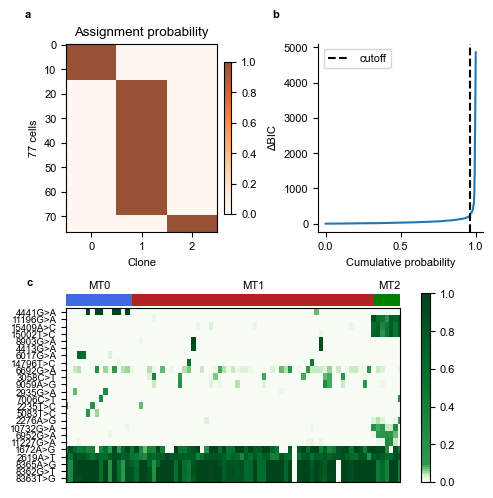

In [26]:
## supp
cm = 1/2.54
fig = plt.figure(figsize=(5,5))
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

ax = plt.subplot2grid((2,2), (0,0), colspan=1)
ax.text(-0.6*cm, 3*cm, 'a', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
im = heat_matrix(ID_prob_sorted, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mquad_modelCA.n_cell))
plt.xticks(range(mquad_modelCA.n_donor))


ax = plt.subplot2grid((2,2), (0,1), colspan=1)
ax.text(-0.6*cm, 3*cm, 'b', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
mquad = pd.read_csv('data/mquad/BIC_params.csv')
x,y,knee_x, knee_y = findKnee(mquad.deltaBIC)
plt.plot(x,y)
plt.axvline(x=knee_x, linestyle='--', color='black', label='cutoff')
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Cumulative probability')
plt.ylabel('\u0394BIC')

ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.text(-0.3*cm, 3*cm, 'c', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='left')
res = ax.imshow(sorted_AF.iloc[g.dendrogram_row.reordered_ind,:], cmap=segment_cmp('Greens'), aspect='auto', interpolation='none')
ax.set_yticks(range(len(sorted_AF)))
ax.set_yticklabels(sorted_AF.iloc[g.dendrogram_row.reordered_ind,:].index, fontsize = 7)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.colorbar(res)

divider = make_axes_locatable(ax)
top_ax = divider.append_axes("top", size=0.13, pad=0.02, sharex=ax)
label_num = [len(clone_id[clone_id == 0]),len(clone_id[clone_id == 1]),len(clone_id[clone_id == 2])]
LEFT = 0
iicolor = 0
c_names = ['MT0', 'MT1', 'MT2']
clone_pal = ['royalblue', 'firebrick', 'green']
for num in label_num:
        top_ax.barh(0,num,left=LEFT,color=clone_pal[iicolor])
        top_ax.text(x=LEFT + num/2, y=1, s=c_names[iicolor], va='center', ha='center')
        top_ax.set_xlim(0,76)
        top_ax.axis('off')
        LEFT += num
        iicolor += 1

plt.tight_layout()
plt.savefig('figures/supp.pdf')